In [1]:
import os
import pandas as pd
import numpy as np
import xgboost
import shap
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score,classification_report
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

In [2]:
test_files = [f for f in os.listdir(".") if f.startswith('trip_records_acs_10_test_')][::2]
print(test_files)
train_files = [f for f in os.listdir(".") if f.startswith('trip_records_acs_10_train_')][::2]
print(train_files)

['trip_records_acs_10_test_0.csv', 'trip_records_acs_10_test_2.csv', 'trip_records_acs_10_test_4.csv', 'trip_records_acs_10_test_6.csv', 'trip_records_acs_10_test_8.csv']
['trip_records_acs_10_train_0.csv', 'trip_records_acs_10_train_2.csv', 'trip_records_acs_10_train_4.csv', 'trip_records_acs_10_train_6.csv', 'trip_records_acs_10_train_8.csv']


In [3]:
%%time

df_train = pd.concat(map(pd.read_csv, train_files))
df_test =  pd.concat(map(pd.read_csv, test_files))

print(df_train.shape,df_test.shape)

(7932812, 121) (1983156, 121)
Wall time: 3min 15s


array([<AxesSubplot:title={'center':'False'}>,
       <AxesSubplot:title={'center':'True'}>], dtype=object)

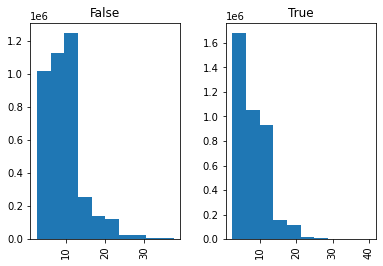

In [66]:
df_train['Fare'].hist(by=df_train.shared)

In [5]:
X_names = ['distance_haversine', 'trip_direction', 'Fare', 'Additional Charges',
        
        'work_day', 'month', 'hour', 'day',
        
        'hour_temp', 'hour_wind', 'rain',
        
        'metro_x','metro_y','pick_dist_dt','drop_dist_dt', 'ln_pop_den_x', 'ln_pop_den_y',
       
       'pct_bach_x', 'median_income_x', 'sex_ratio_x',
        
       'pct_non_white_x', 'pct_age_18_29_x', 'pct_no_car_x',

       'pct_bach_y', 'median_income_y', 'sex_ratio_y',
       'pct_non_white_y', 'median_age_y', 'pct_no_car_y',
       
       'residential_den_x' , 'empoloyment_den_x','job_entropy_x',
        'dist_to_tran_x', 'walkability_x',
        
       'residential_den_y' , 'empoloyment_den_y',
       'job_entropy_y', 'dist_to_tran_y', 'walkability_y',
        
        #'pick_long','pick_lat','drop_long','drop_lat',
        
       ]


In [6]:
X_train = df_train[X_names]
y_train = df_train.shared

X_test = df_test[X_names]
y_test = df_test.shared

In [7]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, df["shared"], 
                                                    #test_size = 0.2, 
                                                    #random_state = 0)


d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [8]:
im = (y_train==False).sum() / (y_train==True).sum()
print(im)

1.0


## Hyper-parameter tuning

In [9]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# Choose hyperparameter domain to search over
space = {
        'max_depth':hp.choice('max_depth', np.arange(1, 21, 1, dtype=int)),
        #'n_estimators':hp.choice('n_estimators', np.arange(40, 2001, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.3, 1.01, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(10, 101, 10, dtype=int)),
        'subsample':        hp.quniform('subsample', 0.4, 1.01, 0.1),
        'learning_rate':    hp.choice('learning_rate',    np.arange(0.02, 0.3, 0.02)),
        'gamma': hp.quniform('gamma', 0, 1, 0.1),

        'objective':'binary:logistic',
        'tree_method' : 'hist',
        'eval_metric': 'logloss',
    }


def inner_cv(X_temp, y_temp,n_evals=1000):
    
    def score(params, n_folds=5):
    
        #Cross-validation
        d_train = xgboost.DMatrix(X_temp,y_temp)
    
        cv_results = xgboost.cv(params, d_train, nfold = n_folds,num_boost_round=300,
                        early_stopping_rounds = 10, metrics = 'logloss', seed = 0)

        loss = min(cv_results['test-logloss-mean'])
        return loss


    def optimize(trials, space):
    
        best = fmin(score, space, algo=tpe.suggest, max_evals=n_evals,
                )#Add seed to fmin function
        return best

    trials = Trials()
    best_params = optimize(trials, space)

    # Return the best parameters
    best_params = space_eval(space, best_params)

    print(best_params)
    return best_params


In [10]:
best_params = inner_cv(X_train, y_train, n_evals=20)

100%|█████████████████████████████████████████████████████| 20/20 [6:28:31<00:00, 1165.55s/trial, best loss: 0.2305062]
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'logloss', 'gamma': 0.5, 'learning_rate': 0.12000000000000001, 'max_depth': 13, 'min_child_weight': 70, 'objective': 'binary:logistic', 'subsample': 0.7000000000000001, 'tree_method': 'hist'}


In [11]:
evals_result = {}

model = xgboost.train(best_params,  d_train, num_boost_round=300, evals = [(d_train,"train"),(d_test, "test")], 
                      verbose_eval=50, early_stopping_rounds=10,evals_result=evals_result)


[0]	train-logloss:0.64413	test-logloss:0.64349
[50]	train-logloss:0.24306	test-logloss:0.24694
[100]	train-logloss:0.22606	test-logloss:0.23339
[150]	train-logloss:0.22100	test-logloss:0.23097
[200]	train-logloss:0.21773	test-logloss:0.22995
[250]	train-logloss:0.21498	test-logloss:0.22937
[299]	train-logloss:0.21274	test-logloss:0.22908


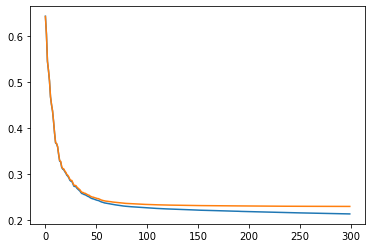

In [12]:
plt.plot(evals_result['train']['logloss'])
plt.plot(evals_result['test']['logloss'])

In [13]:
y_pred = model.predict(d_test)
y_pred_class = (y_pred > 0.50)
acc_xgb = (y_pred_class == y_test.values).sum().astype(float) / len(y_pred_class)*100

print(acc_xgb)

90.63896133234097


In [14]:
y_pred2 = model.predict(d_train)
y_pred_class2 = (y_pred2 > 0.50)
acc_xgb2 = (y_pred_class2 == y_train.values).sum().astype(float) / len(y_pred_class2)*100

print(acc_xgb2)

91.36553343253313


<AxesSubplot:>

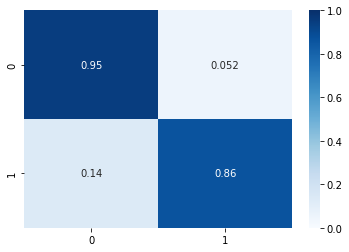

In [15]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred_class,normalize='true'),
            
            vmin=0,vmax=1,cmap='Blues',annot=True)

<AxesSubplot:>

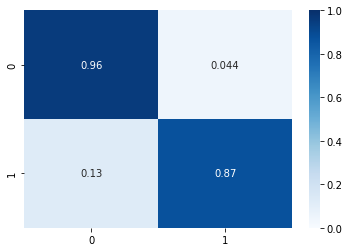

In [16]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_train, y_pred_class2,normalize='true'),
            
            vmin=0,vmax=1,cmap='Blues',annot=True)

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
logit_roc_auc = roc_auc_score(y_test, y_pred_class) 
print(logit_roc_auc)

0.9063896133234097


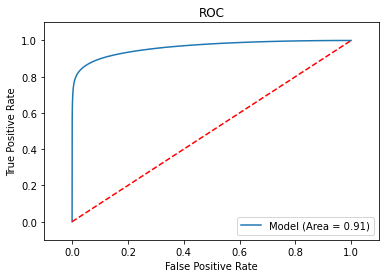

In [18]:
plt.figure()
plt.plot(fpr, tpr, label='Model (Area = %0.2f)' % logit_roc_auc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC')

In [19]:
model.save_model("xgb_no_coords.model")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

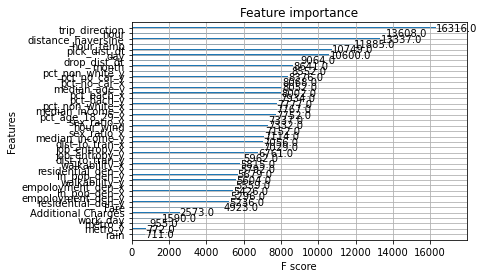

In [20]:
# plot feature importance
xgboost.plot_importance(model)

In [119]:
def od(arr):
    odds = np.exp(arr)
    prob = odds / (1 + odds)
    return prob

In [22]:
%%time

X_sample = X_train.sample(300000)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

Wall time: 1h 58min 35s


In [23]:
np.savetxt('shap_values_3_no_coords.csv', shap_values, delimiter=',')

In [24]:
X_sample.to_csv('shap_X_sample_no_coords.csv')

In [52]:
shap_values.shape

(300000, 39)

In [26]:
#shap_int = explainer.shap_interaction_values(X_sample)

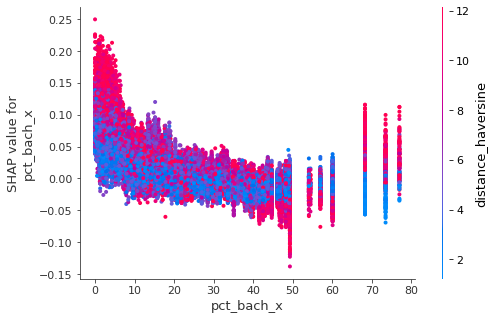

In [112]:
shap.dependence_plot('pct_bach_x', od(shap_values),X_sample.iloc[:,:-4],interaction_index='distance_haversine')

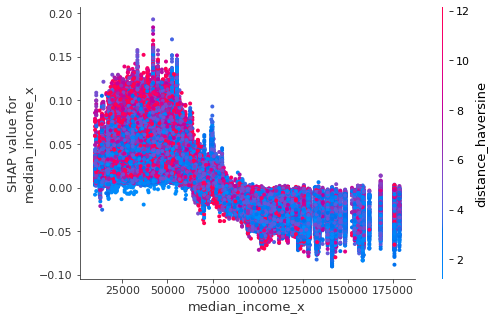

In [111]:
shap.dependence_plot('median_income_x', od(shap_values),X_sample.iloc[:,:-4],interaction_index='distance_haversine')